In [88]:
import csv
import calendar
from datetime import datetime
from datetime import timedelta
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.**


In [75]:
with open('takehome_users.csv', encoding='latin-1') as test:
    s = test.readlines()

In [78]:
p = s[1:]

In [79]:
p

['1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803\n',
 '2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316\n',
 '3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525\n',
 '4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151\n',
 '5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240\n',
 '6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1387424226,0,0,197,11241\n',
 '7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1356009872,0,1,37,\n',
 '8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,,1,1,74,\n',
 '9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,,0,0,302,\n',
 '10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1401833283,1,1,318,4

In [22]:
user_signup = pd.read_csv('takehome_users.csv', encoding='latin-1')
user_login = pd.read_csv('takehome_user_engagement.csv')

In [23]:
user_signup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [24]:
user_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [80]:
user_signup.creation_time = pd.to_datetime(user_signup.creation_time)

In [81]:
user_signup['last_session_creation_time'] = pd.to_datetime(user_signup.last_session_creation_time, unit='s', errors='coerce')

Let's check the users' pattern of logins and look for identifications which can lead to prediction of an adopted user

In [82]:
user_signup.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [37]:
user_login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [83]:
user_login.time_stamp = pd.to_datetime(user_login.time_stamp)

**1. Find time frame of 3 consecutive logins.**

Find time difference between each login and two logins ago, by user. This gives time frame of 3 consecutive logins and will be used to define "adopted user". Also check number of days between logins to make sure the logins are on separate days.

In [84]:
def time_difference(group):
    group['time_for_three'] = group['time_stamp'].diff(periods=2)
    group['days_from_last_login'] = group['time_stamp'].diff(periods=1)//pd.Timedelta(days=1)
    return group

user_login = user_login.groupby('user_id').apply(time_difference)

In [85]:
user_login.head()

,time_stamp,user_id,visited,time_for_three,days_from_last_login
0,2014-04-22 03:53:30,1,1,NaT,NaN
1,2013-11-15 03:45:04,2,1,NaT,NaN
2,2013-11-29 03:45:04,2,1,NaT,14.0
3,2013-12-09 03:45:04,2,1,24 days,10.0
4,2013-12-25 03:45:04,2,1,26 days,16.0


**2. Define "adopted user".**

In [89]:
min_delta_by_user = user_login.groupby('user_id')['time_for_three'].min()
min_delta_by_user[min_delta_by_user < timedelta(days=7)]

user_id
2       5 days
10      2 days
20      2 days
33      6 days
42      2 days
         ...  
11965   3 days
11967   2 days
11969   2 days
11975   2 days
11988   2 days
Name: time_for_three, Length: 1602, dtype: timedelta64[ns]

In [90]:
min_delta_by_user[min_delta_by_user >= timedelta(days=7)]

user_id
59      83 days
60       7 days
77      28 days
95      16 days
126     19 days
          ...  
11948   31 days
11949    9 days
11980    9 days
11981   12 days
11991    8 days
Name: time_for_three, Length: 646, dtype: timedelta64[ns]

In [91]:
min_delta_by_user[min_delta_by_user.isnull()]

user_id
1       NaT
3       NaT
4       NaT
5       NaT
6       NaT
         ..
11996   NaT
11997   NaT
11998   NaT
11999   NaT
12000   NaT
Name: time_for_three, Length: 6575, dtype: timedelta64[ns]

**3. Results**

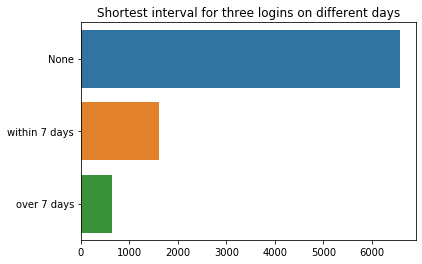

In [113]:
labels = ['None', 'within 7 days', 'over 7 days']
sizes = [min_delta_by_user.isnull().sum(), 
         (min_delta_by_user < timedelta(days=7)).sum(), 
         (min_delta_by_user >= timedelta(days=7)).sum()]

sns.barplot(sizes, labels )
plt.title('Shortest interval for three logins on different days')
plt.show()

There are not so many users who can be called 'adopted' since most of them won't sign-in again. Intuitively, i think to look after the data/columns which can create a valid dimensional space. Feature extraction of columns is possible with also keeping in mind the 'scaling'. Meaning, it is not possible to just merge columns. There should an additionaly space being created for any additional feature. From the given columns, i would suggest to work with: 'creation_time', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip' and 'invited_by_user_id'